In [1]:
import math
import numpy as np
import scipy.special as sp
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from numba import jit,int64,float64
import time
import scipy.optimize as sciopt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Plot template

# fig,ax = plt.subplots(1,1)
# ax.scatter(alphas_arr,stabilities_arr[:,0],c=CB_color_cycle[0],marker=">",label="fate 1")
# ax.scatter(alphas_arr,stabilities_arr[:,1],c=CB_color_cycle[1],marker="<",label="fate 2",alpha=1)
# ax.axhline(y=stability_thresh,c="k",ls="--",label="threshold")
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r"Noise coefficient $\alpha$",fontsize=18)
# ax.set_ylabel(r"Mean stability factor",fontsize=18)
# ax.legend(loc="best",fontsize=12)
# ax.set_title(f"Stability vs. noise",fontsize=20)
# fig.savefig("1b_stability_vs_noise.svg",format="svg")

#Color-blind friendly colors to plot:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [3]:
#Parameters - self-activation a, cross-repression r, decay k, noise alpha:
a = np.array([0,0])
r = np.array([1,1])
k = np.array([1,1])
alpha = np.array([0.1,0.1])
#Hill coefficients:
n = np.array([[4,4],[4,4]])
theta = np.array([[0.5,0.5],[0.5,0.5]])

#The total time and dt::
T = 40
dt = 0.005
#Other time-related variables related to these two:
Nt = int(T/dt)
sqrt_dt = np.sqrt(dt)
TimeRange = np.arange(0,T,dt)
# #This is to calculate the dynamic threshold moving average:
# timeBase = 2*int(Nt/100)
# #Time to plot utility against:
# time_trunc = TimeRange[int((timeBase/2)-1):-int(timeBase/2)]

#Let's call num_traj the number of trajectories:
num_traj = 10000

#The initial conditions:
x0 = np.zeros((2,num_traj))
#Uniform around mean:
init_bias = 0.1
x0[0,:] = init_bias*np.ones(num_traj)

#The threshold above which we say x_i is high:
thresh = np.array([0.8,0.8])
#The stability threshold; a trajectory has to stay above this:
stability_thresh = 0.9

#Color-blind friendly colors to plot:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [4]:
#Self-activation:
@jit(nopython=True)
def activation(x,a,n,theta):
    if (x>=0):
        return (a*x**n)/(x**n + theta**n)
    else:
        return 0

#Cross-inhibition
@jit(nopython=True)
def repression(x,r,n,theta):
    if (x>0):
        return (r*theta**n)/(x**n + theta**n)
    else:
        return 0

#Bias (for external signals):
@jit(nopython=True)
def ext_bias(x1,x2,t):
#     return (x1-x2,x2-x1)
    temp = 0
    return (temp,0)
    
#This solves the system fwd using simple Euler-Maruyama:
@jit(nopython=True)
def Solver(initial,a,r,k,n,theta,alpha):
    final = np.empty((2,num_traj,Nt))
    final[:,:,0] = initial
    #Solving the system forward in time:
    for i in range(num_traj):
        for t in range(1,Nt):
            #Equation for first species:
            temp = np.sqrt(np.maximum(final[0,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[0]*temp)
            final[0,i,t] = final[0,i,t-1] + dt*(activation(final[0,i,t-1],a[0],n[0,0],theta[0,0]) \
                                               + repression(final[1,i,t-1],r[0],n[1,0],theta[1,0]) \
                                               - k[0]*final[0,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[0]) \
                                                + sqrt_dt*noise
            #Equation for second:
            temp = np.sqrt(np.maximum(final[1,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[1]*temp)
            final[1,i,t] = final[1,i,t-1] + dt*(activation(final[1,i,t-1],a[1],n[1,1],theta[1,1]) \
                                               + repression(final[0,i,t-1],r[1],n[0,1],theta[0,1]) \
                                               - k[1]*final[1,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[1]) \
                                                + sqrt_dt*noise
    return final

#Classifier:
# @jit(nopython=True)
def fate_classifier(traj,thresh,stability_thresh):
    #Stability factor of trajectories:
    cross_flags = np.zeros((2,num_traj))
    cross_times = np.ones((2,num_traj))*Nt
    for axis_idx in range(2):
        #Axis crossings:
        for traj_idx in range(num_traj):
            if (np.size(np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0]) != 0):
                cross_flags[axis_idx,traj_idx] = 1
                cross_times[axis_idx,traj_idx] = np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0][0]
                    
    #Stability factor: after the threshold is crossed, how much time the traj spends above it:
    stability_factrs = np.zeros((2,num_traj))
    for axis_idx in range(2):
        for traj_idx in range(num_traj):
#             if (cross_flags[axis_idx,traj_idx]==0):
#                 stability_factrs[axis_idx,traj_idx] = -1
            if (cross_flags[axis_idx,traj_idx]==1):
                stability_factrs[axis_idx,traj_idx] = np.sum(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):]>thresh[axis_idx])\
                /len(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):])
    
    #Stability threshold - trajectories that spend more than this above the concentration threshold are considered committed:
#     stability_thresh = 0.8
    #Classifying fates:
    fates = np.zeros((2,num_traj))
    for axis_idx in range(2):
        for traj_idx in range(num_traj):
            if (cross_times[axis_idx,traj_idx]<=int(Nt/2) and stability_factrs[axis_idx,traj_idx]>=stability_thresh):
                fates[axis_idx,traj_idx]=1
                
    return stability_factrs,fates

def fate_fractions(fates):
    #Initializing:
    fate_frax = np.zeros(4)
    fate_frax[0] = np.sum((fates[0]==0) & (fates[1]==0))/num_traj
    fate_frax[1] = np.sum((fates[0]==1) & (fates[1]==0))/num_traj
    fate_frax[2] = np.sum((fates[0]==0) & (fates[1]==1))/num_traj
    fate_frax[3] = np.sum((fates[0]==1) & (fates[1]==1))/num_traj
    
    return fate_frax

def traj_moments(traj,fates):
    #Finding the fate fractions first:
    fate_frax = fate_fractions(fates)
    
    #Flags, if fate_frac is zero for a fate then no avg or std is calculated:
    fate_flags = np.array([False for i in range(4)])
    
    #Flag = True if that fate exists in the population:
    for fate_idx in range(4):
        if (fate_frax[fate_idx] != 0):
            fate_flags[fate_idx] = True
            
    #Average trajectories and standard deviation around them:
    avg_traj = np.zeros((4,2,Nt))
    std_traj = np.zeros((4,2,Nt))
    
    if (fate_flags[0]==True):
        avg_traj[0,:,:] = np.mean(traj[:,(fates[0]==0) & (fates[1]==0),:],axis=1)
        std_traj[0,:,:] = np.std(traj[:,(fates[0]==0) & (fates[1]==0),:],axis=1)

    if (fate_flags[1]==True):
        avg_traj[1,:,:] = np.mean(traj[:,(fates[0]==1) & (fates[1]==0),:],axis=1)
        std_traj[1,:,:] = np.std(traj[:,(fates[0]==1) & (fates[1]==0),:],axis=1)

    if (fate_flags[2]==True):
        avg_traj[2,:,:] = np.mean(traj[:,(fates[0]==0) & (fates[1]==1),:],axis=1)
        std_traj[2,:,:] = np.std(traj[:,(fates[0]==0) & (fates[1]==1),:],axis=1)

    if (fate_flags[3]==True):
        avg_traj[3,:,:] = np.mean(traj[:,(fates[0]==1) & (fates[1]==1),:],axis=1)
        std_traj[3,:,:] = np.std(traj[:,(fates[0]==1) & (fates[1]==1),:],axis=1)
        
    return (avg_traj,std_traj)

In [5]:
#Generating some trajectories:
start_time = time.time()
traj_simple = np.empty((2,num_traj,Nt))
traj_simple = Solver(x0,a,r,k,n,theta,alpha)
end_time = time.time()
loop_time = end_time - start_time
print(f"Time taken: {loop_time} s.")

Time taken: 13.367586612701416 s.


In [6]:
#Now testing the fates and stability factors:
stability_factrs,fates = fate_classifier(traj_simple,thresh,stability_thresh)

In [7]:
#Thetas, alphas and initial biases:
thetas_arr = np.arange(0.3,0.75,0.05)
alphas_arr = np.array([0.01,0.05,0.1])
init_bias_arr = np.array([i/100 for i in range(6)])

#Stabilities and fate fractions:
stabilities_mean_arr = np.zeros((len(alphas_arr),len(thetas_arr),2))
stabilities_std_arr = np.zeros((len(alphas_arr),len(thetas_arr),2))
fate_frax = np.zeros((len(alphas_arr),len(thetas_arr),len(init_bias_arr),4))

for alpha_idx in range(len(alphas_arr)):
    alpha[0] = alpha[1] = alphas_arr[alpha_idx]
    for theta_idx in range(len(thetas_arr)):
        #Setting theta:
        theta[0,1] = theta[1,0] = thetas_arr[theta_idx]
        for bias_idx in range(len(init_bias_arr)):
            #Initial conditions:
            x0 = np.zeros((2,num_traj))
            x0[0,:] = init_bias_arr[bias_idx]*np.ones(num_traj)
            #Evolving:
            traj_alpha_theta_bias = Solver(x0,a,r,k,n,theta,alpha)
            #Checking fates:
            stability_factrs,fates = fate_classifier(traj_alpha_theta_bias,thresh,stability_thresh)
            fate_frax[alpha_idx,theta_idx,bias_idx] = fate_fractions(fates)
            #Finding mean stabilities:
            if (bias_idx==0):
                for axis_idx in range(2):
                    #If fate 1 or 2 are empty, i.e. every trajectory is undecided:
                    if (stability_factrs[axis_idx,stability_factrs[axis_idx]>0].size==0):
                        stabilities_mean_arr[alpha_idx,theta_idx,axis_idx] = 0
                        stabilities_std_arr[alpha_idx,theta_idx,axis_idx] = 0
                    else:
                        stabilities_mean_arr[alpha_idx,theta_idx,axis_idx] = np.mean(stability_factrs[axis_idx,stability_factrs[axis_idx]>0])
                        stabilities_std_arr[alpha_idx,theta_idx,axis_idx] = np.std(stability_factrs[axis_idx,stability_factrs[axis_idx]>0])

KeyboardInterrupt: 

In [72]:
stabilities_mean_arr+stabilities_std_arr

array([[[1.0000225 , 1.00002201],
        [1.00002699, 1.0000237 ],
        [1.00002831, 1.00002642],
        [1.00003439, 1.00003448],
        [1.00004205, 1.00004272],
        [1.00006052, 1.0000584 ],
        [1.00009705, 1.00009417],
        [1.0001328 , 1.00013231],
        [1.0002372 , 1.0002099 ]],

       [[1.00260265, 1.00264942],
        [1.0005902 , 1.00063664],
        [1.0006439 , 1.00068301],
        [1.00078276, 1.00076637],
        [1.00089102, 1.00080061],
        [1.00106087, 1.0010394 ],
        [1.00131655, 1.00135084],
        [1.00188554, 1.00188305],
        [1.00271053, 1.00276289]],

       [[0.96932995, 0.96957912],
        [1.00106644, 1.00082679],
        [1.00164739, 1.00159466],
        [1.00167837, 1.00181065],
        [1.00172011, 1.00181385],
        [1.00181883, 1.0020698 ],
        [1.00216092, 1.00838921],
        [1.00301084, 1.01234544],
        [1.04632483, 1.03886269]]])

In [73]:
stabilities_mean_arr-stabilities_std_arr

array([[[0.99997024, 0.99997129],
        [0.99996434, 0.99996909],
        [0.99996083, 0.99996357],
        [0.99995095, 0.99995081],
        [0.99993528, 0.99993544],
        [0.99990041, 0.99990643],
        [0.99983055, 0.99983308],
        [0.99972836, 0.99973429],
        [0.99948451, 0.99951455]],

       [[0.99220802, 0.99216686],
        [0.99827173, 0.99820501],
        [0.99802014, 0.99801233],
        [0.99762152, 0.99767579],
        [0.99715839, 0.99726064],
        [0.99633431, 0.99633562],
        [0.99488748, 0.99475108],
        [0.99220549, 0.99208439],
        [0.98707068, 0.98691031]],

       [[0.90446394, 0.90473375],
        [0.97772648, 0.97704365],
        [0.98894827, 0.98929643],
        [0.98836488, 0.98819799],
        [0.9867163 , 0.9867892 ],
        [0.98466056, 0.98346471],
        [0.97904905, 0.97236508],
        [0.97035175, 0.95882971],
        [0.89998442, 0.90996502]]])

In [85]:
#Writing results to text files:
np.savetxt(fr"2c_fatefrax_2.txt",fate_frax.flatten())
np.savetxt(fr"2c_stabilities_mean_2.txt",stabilities_mean_arr.flatten())
np.savetxt(fr"2c_stabilities_std_2.txt",stabilities_std_arr.flatten())

In [12]:
#Loading the saved results:
fate_frax = np.loadtxt("2c_fatefrax_2.txt").reshape((len(alphas_arr),len(thetas_arr),len(init_bias_arr),4))
stabilities_mean_arr = np.loadtxt("2c_stabilities_mean_2.txt").reshape((len(alphas_arr),len(thetas_arr),2))
stabilities_std_arr = np.loadtxt("2c_stabilities_std_2.txt").reshape((len(alphas_arr),len(thetas_arr),2))

In [13]:
fate_frax[:,:,:,0]

array([[[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.000e-04, 3.000e-04, 1.000e-04, 0.000e+00, 1.000e-04,
         0.000e+00],
        [9.000e-04, 1.000e-03, 1.200e-03, 5.000e-04, 1.000e-04,
         1.000e-04]],

       [[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,

In [14]:
#Defining the sensitivities as a function of theta and alpha:
sensitivity = np.zeros((len(alphas_arr),len(thetas_arr)))

#Linear function to fit against:
def fit_linear(x,a,b):
    return a*x+b

#x-coordinates for fit:
x_fit = init_bias_arr

for alpha_idx in range(len(alphas_arr)):
    for theta_idx in range(len(thetas_arr)):
        if (alpha_idx==0):
            x_fit = init_bias_arr[:3]
            y_fit = fate_frax[alpha_idx,theta_idx,:3,1]
        else:
            x_fit = init_bias_arr
            y_fit = fate_frax[alpha_idx,theta_idx,:,1]
        popt,pcov = sciopt.curve_fit(fit_linear,x_fit,y_fit,p0=([2,0.1]))
        sensitivity[alpha_idx,theta_idx] = popt[0]

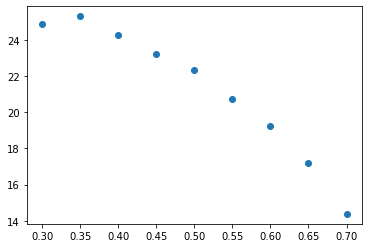

In [15]:
plt.scatter(thetas_arr,sensitivity[0])

Text(0.2, 0.94, 'Sensitivity and stability vs. $\\theta_{xy}$ and $\\alpha$')

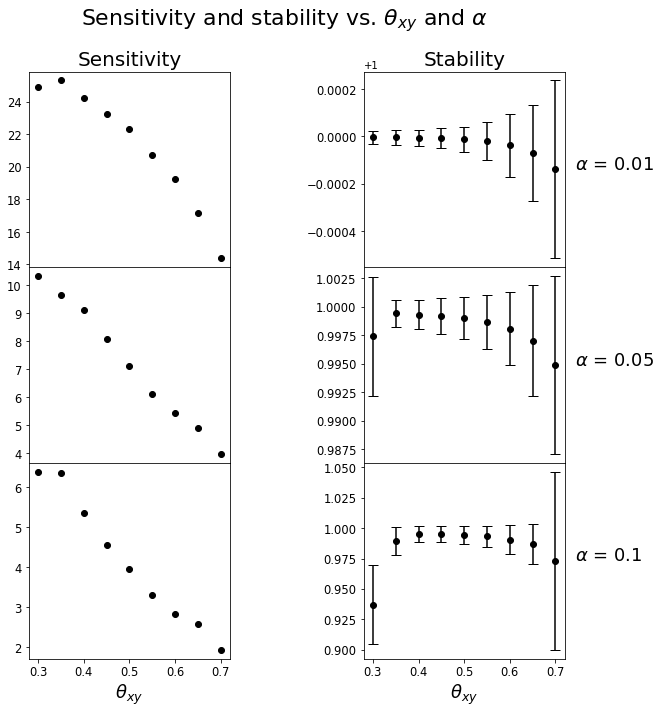

In [16]:
fig,ax = plt.subplots(3,2,figsize=[9.6,10.8],sharex=True)

for row_idx in range(3):
    for col_idx in range(2):
        ax[row_idx,col_idx].tick_params(axis='both', which='major', labelsize=11.5)
        ax[row_idx,col_idx].tick_params(axis='both', which='minor', labelsize=9)

ax[0,0].scatter(thetas_arr,sensitivity[0],color="k")
ax[0,0].set_title("Sensitivity",fontsize=20)

ax[0,1].errorbar(thetas_arr,stabilities_mean_arr[0,:,0],yerr=stabilities_std_arr[0,:,0],fmt="o",capsize=5,color="k")
ax[0,1].text(1.05,0.5,fr"$\alpha$ = {alphas_arr[0]}",transform=ax[0,1].transAxes,fontsize=18)
ax[0,1].set_title("Stability",fontsize=20)

# ax[0,2].scatter(thetas_arr,np.mean(fate_frax[:,:,:,0],axis=2)[0])

ax[1,0].scatter(thetas_arr,sensitivity[1],color="k")

ax[1,1].errorbar(thetas_arr,stabilities_mean_arr[1,:,0],yerr=stabilities_std_arr[1,:,0],fmt="o",capsize=5,color="k")
ax[1,1].text(1.05,0.5,fr"$\alpha$ = {alphas_arr[1]}",transform=ax[1,1].transAxes,fontsize=18)

# ax[1,2].scatter(thetas_arr,np.mean(fate_frax[:,:,:,0],axis=2)[1])

ax[2,0].scatter(thetas_arr,sensitivity[2],color="k")
ax[2,0].set_xlabel(r"$\theta_{xy}$",fontsize=18)

ax[2,1].errorbar(thetas_arr,stabilities_mean_arr[2,:,0],yerr=stabilities_std_arr[2,:,0],fmt="o",capsize=5,color="k")
ax[2,1].set_xlabel(r"$\theta_{xy}$",fontsize=18)
ax[2,1].text(1.05,0.5,fr"$\alpha$ = {alphas_arr[2]}",transform=ax[2,1].transAxes,fontsize=18)

# ax[2,2].scatter(thetas_arr,np.mean(fate_frax[:,:,:,0],axis=2)[2])


# ax[0].fill_between(init_bias_arr,y1=fate_frax[0,:,0],color=CB_color_cycle[0],alpha=1,label="fate 0")
# ax[0].fill_between(init_bias_arr,y1=fate_frax[0,:,1]+fate_frax[0,:,0],y2=fate_frax[0,:,0],color=CB_color_cycle[1],alpha=1,label="fate 1")
# ax[0].fill_between(init_bias_arr,y1=fate_frax[0,:,2]+fate_frax[0,:,1]+fate_frax[0,:,0],y2=fate_frax[0,:,1]+fate_frax[0,:,0],color=CB_color_cycle[2],alpha=1,label="fate 2")
# ax[0].legend(loc="best",fontsize=12)
# ax[0].set_ylabel(r"$f_i$",fontsize=18)
# ax[0].text(1.01,0.5,fr"$\theta_{{xy}}$ = {thetas_arr[0]}",transform=ax[0].transAxes,fontsize=16)
# ax[0].set_title(fr"Fate shares vs. initial bias ($\alpha$ = {alpha[0]})",fontsize=22)

# ax[1].fill_between(init_bias_arr,y1=fate_frax[1,:,0],color=CB_color_cycle[0],alpha=1)
# ax[1].fill_between(init_bias_arr,y1=fate_frax[1,:,1]+fate_frax[1,:,0],y2=fate_frax[1,:,0],color=CB_color_cycle[1],alpha=1)
# ax[1].fill_between(init_bias_arr,y1=fate_frax[1,:,2]+fate_frax[1,:,1]+fate_frax[1,:,0],y2=fate_frax[1,:,1]+fate_frax[1,:,0],color=CB_color_cycle[2],alpha=1)
# ax[1].set_ylabel(r"$f_i$",fontsize=18)
# ax[1].text(1.01,0.5,fr"$\theta_{{xy}}$ = {thetas_arr[1]}",transform=ax[1].transAxes,fontsize=16)

# ax[2].fill_between(init_bias_arr,y1=fate_frax[2,:,0],color=CB_color_cycle[0],alpha=1)
# ax[2].fill_between(init_bias_arr,y1=fate_frax[2,:,1]+fate_frax[2,:,0],y2=fate_frax[2,:,0],color=CB_color_cycle[1],alpha=1)
# ax[2].fill_between(init_bias_arr,y1=fate_frax[2,:,2]+fate_frax[2,:,1]+fate_frax[2,:,0],y2=fate_frax[2,:,1]+fate_frax[2,:,0],color=CB_color_cycle[2],alpha=1)
# ax[2].set_ylabel(r"$f_i$",fontsize=18)
# ax[2].text(1.01,0.5,fr"$\theta_{{xy}}$ = {thetas_arr[2]}",transform=ax[2].transAxes,fontsize=16)
# ax[2].set_xlabel(r"Initial bias",fontsize=18)

plt.subplots_adjust(wspace=2/3,hspace=0)

fig.text(0.2,0.94,r"Sensitivity and stability vs. $\theta_{xy}$ and $\alpha$",fontsize=22)

# fig.savefig("2a_sensitivity&stability_vs_theta&alpha.eps",format="eps",dpi=2000,bbox_inches="tight",pad_inches=0.15)